# Load libraries and data

Enter your project root:

In [5]:
project_root = "/home/dan1dr/zrive-ds-4q24-churn"

In [6]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb


# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger

logger = get_logger(__name__)

Already in the correct path


### Extract the data from BigQuery

Define the query:

In [ ]:
query_sql_22 = """
WITH selectable_customer AS
(
         SELECT   customer_id
         FROM     `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
         GROUP BY customer_id ), customer_selected AS
(
       SELECT customer_id AS selected_customer
       FROM   selectable_customer
       WHERE  RAND() < 0.1 )
SELECT     customer_id,
           MONTH,
           YEAR,
           pago_final_0,
           dif_pago_final_prev_month,
           dif_pago_final_prev_2_month,
           dif_pago_final_prev_3_month,
           periodica_0,
           dif_periodica_prev_month,
           dif_periodica_prev_2_month,
           dif_periodica_prev_3_month,
           consumo_0,
           dif_consumo_prev_month,
           dif_consumo_prev_2_month,
           dif_consumo_prev_3_month,
           aperiodica_0,
           dif_aperiodica_prev_month,
           dif_aperiodica_prev_2_month,
           dif_aperiodica_prev_3_month,
           discount_0,
           dif_discount_prev_month,
           dif_discount_prev_2_month,
           dif_discount_prev_3_month,
           ajuste_0,
           dif_ajuste_prev_month,
           dif_ajuste_prev_2_month,
           dif_ajuste_prev_3_month,
           Tota_Compra_disp,
           Curr_Compra_disp,
           Curr_Compra_Finanz_disp,
           Curr_Finanz_disp,
           Month_purchase_disp,
           Modelo_disp,
           Import_Rest_quota_disp,
           pvp_total_disp,
           pvp_total_disp_movil,
           Curr_cancel_disp,
           Tota_cancel_disp NUM_GB_OWNN_CURR,
           NUM_GB_2G_CURR,
           NUM_GB_3G_CURR,
           NUM_GB_4G_CURR,
           NUM_GB_5G_CURR,
           NUM_SESS_CURR,
           NUM_SECS_CURR,
           NUM_CALL_CURR,
           NUM_CALL_WEEK_CURR,
           NUM_CALL_WEEKEND_CURR,
           NUM_SECS_WEEK_CURR,
           NUM_SECS_WEEKEND_CURR,
           NUM_CALL_WEEK,
           NUM_CALL_WEEKEND,
           NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
FROM       `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON         customer_id = selected_customer
WHERE      IS_CUST_SEGM_RESI > 0
AND        IS_CUST_BILL_POST_CURR = TRUE
AND        CUST_BUNDLE_CURR = 'FMC'
AND        NUM_IMPAGOS = 0
AND        pago_final_0 IS NOT NULL
"""

In [18]:
query_sql_23 = """SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
  """

In [5]:
sample = data_gathering(query_sql_22)
logger.info(f"Extraction completed - data_2022")
# data_2023 = data_gathering(query_sql_23)
# logging.info(f"Extraction completed - data_2023")

INFO - Extraction completed - data_2022


### Save the data

In [8]:
save_path = os.path.join(project_root, "data")
sample.to_parquet(os.path.join(save_path, "subsample_users.parquet"))

### Load the data

In [7]:
save_path = "/home/dan1dr/zrive-ds-4q24-churn/data"
read_path = os.path.join(save_path, "subsample_users.parquet")
sample = pd.read_parquet(read_path)

## Explore data

In [8]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [15]:
sample[sample["customer_id"] == "620962"].sort_values(by="MONTH")

,customer_id,MONTH,YEAR,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,dif_consumo_prev_month,dif_consumo_prev_2_month,dif_consumo_prev_3_month,dif_discount_prev_month,dif_discount_prev_2_month,dif_discount_prev_3_month,pago_final_0,NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
328,620962,01,2022,-0.60,-0.30,0.00,54.87,72.50,118.20,-55.47,-72.80,-118.20,71.0449,<NA>
1090,620962,02,2022,4.49,3.89,4.19,-95.69,-40.82,-23.19,100.18,44.71,27.38,75.5396,<NA>
894,620962,03,2022,10.36,14.86,14.26,-35.51,-131.20,-76.33,43.30,143.48,88.01,85.9020,<NA>
1706,620962,04,2022,-29.71,-19.35,-14.86,28.83,-6.69,-102.37,-41.11,2.19,102.37,56.1878,<NA>
1039,620962,05,2022,15.22,-14.49,-4.13,-33.41,-4.58,-40.10,33.77,-7.33,35.97,71.4079,<NA>
368,620962,06,2022,-0.36,14.86,-14.86,69.93,36.52,65.34,-70.29,-36.52,-77.62,71.0449,<NA>
1692,620962,07,2022,1.59,1.22,16.44,35.47,105.40,71.99,-29.49,-99.78,-66.01,72.6305,<NA>
273,620962,08,2022,11.22,12.81,12.44,-34.99,0.48,70.41,49.48,19.99,-50.30,83.8512,<NA>
414,620962,09,2022,-18.16,-6.94,-5.35,104.33,69.33,104.81,-95.90,-46.41,-75.90,65.6949,<NA>
1,620962,10,2022,22.35,4.19,15.41,-165.29,-60.96,-95.95,163.79,67.89,117.37,88.0450,<NA>


In [9]:
sample.head()

,customer_id,MONTH,YEAR,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,consumo_0,dif_consumo_prev_month,dif_consumo_prev_2_month,dif_consumo_prev_3_month,aperiodica_0,dif_aperiodica_prev_month,dif_aperiodica_prev_2_month,dif_aperiodica_prev_3_month,discount_0,dif_discount_prev_month,dif_discount_prev_2_month,dif_discount_prev_3_month,ajuste_0,dif_ajuste_prev_month,dif_ajuste_prev_2_month,dif_ajuste_prev_3_month,Tota_Compra_disp,Curr_Compra_disp,Curr_Compra_Finanz_disp,Curr_Finanz_disp,Month_purchase_disp,Modelo_disp,Import_Rest_quota_disp,pvp_total_disp,pvp_total_disp_movil,Curr_cancel_disp,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,NUM_GB_5G_CURR,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
0,4142337,12,2022,87.1499,-0.92,5.00,13.15,123.2162,0.0,0.82,2.23,440.7130,-83.33,109.00,-288.48,0.0,0.00,0.00,0.0,-476.7793,82.40,-104.83,299.39,0.0,0.0,0.0,0.0,6,0,0,2,3,1,758.676250,2355.36,2355.36,0,0,0.000379,1.478475,34.539025,8.552260,12871,88554,820,624,196,69564,18990,471,140,<NA>
1,620962,10,2022,88.0450,22.35,4.19,15.41,174.9015,0.0,-2.74,-6.01,244.8217,-165.29,-60.96,-95.95,0.0,23.85,0.00,0.0,-331.6782,163.79,67.89,117.37,0.0,0.0,0.0,0.0,9,0,0,2,9,1,173.550000,1433.05,1433.05,0,0,0.003215,0.943611,14.486598,0.000000,11221,104166,564,408,156,68144,36022,300,113,<NA>
2,127593,01,2022,177.5206,0.89,22.48,2.95,254.5857,0.0,-1.35,-5.09,69.6490,33.88,29.52,7.54,0.0,0.00,-0.73,0.0,-146.7141,-32.99,-4.96,0.50,0.0,0.0,0.0,0.0,8,0,0,0,18,1,54.546250,1436.23,1436.23,0,0,0.000995,0.084578,24.819340,0.000000,4390,9911,154,109,45,7230,2681,100,34,<NA>
3,1464466,07,2022,106.6281,7.58,7.51,11.08,218.4490,-2.3,-2.30,-1.69,123.9285,-39.25,-67.05,-155.04,0.0,0.00,0.00,0.0,-235.7494,49.13,76.86,167.81,0.0,0.0,0.0,0.0,6,0,0,1,3,1,212.394583,1572.89,1434.05,0,0,0.014278,2.380983,23.064308,1.185673,15480,34602,476,337,139,23975,10627,308,115,<NA>
4,311788,11,2022,159.0900,-0.60,-1.50,3.00,217.1160,0.0,0.00,0.52,125.9174,-29.83,-58.43,-20.02,0.0,0.00,0.00,0.0,-183.9434,29.23,56.93,22.50,0.0,0.0,0.0,0.0,6,0,0,0,17,1,40.495000,972.89,972.89,0,0,0.002118,0.373219,137.773213,0.000000,25080,37916,265,194,71,25642,12274,168,51,<NA>


In [10]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283442 entries, 0 to 283441
Data columns (total 52 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   customer_id                       283442 non-null  object 
 1   MONTH                             283442 non-null  object 
 2   YEAR                              283442 non-null  object 
 3   pago_final_0                      283442 non-null  float64
 4   dif_pago_final_prev_month         283442 non-null  float64
 5   dif_pago_final_prev_2_month       283442 non-null  float64
 6   dif_pago_final_prev_3_month       283442 non-null  float64
 7   periodica_0                       283442 non-null  float64
 8   dif_periodica_prev_month          283442 non-null  float64
 9   dif_periodica_prev_2_month        283442 non-null  float64
 10  dif_periodica_prev_3_month        283442 non-null  float64
 11  consumo_0                         283442 non-null  f

In [11]:
sample.columns.tolist()

['customer_id',
 'MONTH',
 'YEAR',
 'pago_final_0',
 'dif_pago_final_prev_month',
 'dif_pago_final_prev_2_month',
 'dif_pago_final_prev_3_month',
 'periodica_0',
 'dif_periodica_prev_month',
 'dif_periodica_prev_2_month',
 'dif_periodica_prev_3_month',
 'consumo_0',
 'dif_consumo_prev_month',
 'dif_consumo_prev_2_month',
 'dif_consumo_prev_3_month',
 'aperiodica_0',
 'dif_aperiodica_prev_month',
 'dif_aperiodica_prev_2_month',
 'dif_aperiodica_prev_3_month',
 'discount_0',
 'dif_discount_prev_month',
 'dif_discount_prev_2_month',
 'dif_discount_prev_3_month',
 'ajuste_0',
 'dif_ajuste_prev_month',
 'dif_ajuste_prev_2_month',
 'dif_ajuste_prev_3_month',
 'Tota_Compra_disp',
 'Curr_Compra_disp',
 'Curr_Compra_Finanz_disp',
 'Curr_Finanz_disp',
 'Month_purchase_disp',
 'Modelo_disp',
 'Import_Rest_quota_disp',
 'pvp_total_disp',
 'pvp_total_disp_movil',
 'Curr_cancel_disp',
 'NUM_GB_OWNN_CURR',
 'NUM_GB_2G_CURR',
 'NUM_GB_3G_CURR',
 'NUM_GB_4G_CURR',
 'NUM_GB_5G_CURR',
 'NUM_SESS_CURR',
 

In [132]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls


nulls = assess_NA(sample)

In [13]:
nulls.head(20)

,index,count,percent
0,customer_id,0,0.0
1,MONTH,0,0.0
2,YEAR,0,0.0
3,pago_final_0,0,0.0
4,dif_pago_final_prev_month,0,0.0
5,dif_pago_final_prev_2_month,0,0.0
6,dif_pago_final_prev_3_month,0,0.0
7,periodica_0,0,0.0
8,dif_periodica_prev_month,0,0.0
9,dif_periodica_prev_2_month,0,0.0


In [14]:
na_info_sorted = nulls.sort_values(by="percent", ascending=False)
na_info_sorted.head(20)

,index,count,percent
51,NUM_DAYS_LINE_TYPE_FIXE_POST_DEA,266102,93.882346
33,Import_Rest_quota_disp,225676,79.619816
31,Month_purchase_disp,183121,64.606163
32,Modelo_disp,183121,64.606163
35,pvp_total_disp_movil,183121,64.606163
34,pvp_total_disp,179070,63.176946
37,NUM_GB_OWNN_CURR,175367,61.870506
28,Curr_Compra_disp,175367,61.870506
29,Curr_Compra_Finanz_disp,175367,61.870506
30,Curr_Finanz_disp,175367,61.870506


In [11]:
sample["customer_id"].nunique()

26312

* 26k unique users in this subsample
* 7% of positive class

### Prepare data for first model

1. First selection of cols (let's include this in ``data_cleaning()``)
2. Clean, normalize, drop, etc (idem)
3. Create feature target (`feature_computation()`)
4. Agreggate data if needed to reflect the past user behavior (idem)


We said we will use for the moment the current precooked metrics for payments, discounts, and consumpitons, which are given by difference month on month. Additionally, let's try to add one col `pago_final_0` and compute the rolling avg for the last 3 months e.g

*IMPORTANT INFO*. First we will use a logistic regression for training our first model, so we should keep an eye on NANs and possible outliers. Later on, when moving into lightGBM this will be less important as it handle those cases natively (same for scaling).

** There is an user that from one month to other, data for the required filter becomes null. Inspect*** -> customer_id = 1322985

In [4]:
# user-info cols to aggregate data later on
users_cols = ["customer_id", "MONTH", "YEAR"]

# pre-cooked features
diff_cols = [
    "dif_pago_final_prev_month",
    "dif_pago_final_prev_2_month",
    "dif_pago_final_prev_3_month",
    "dif_consumo_prev_month",
    "dif_consumo_prev_2_month",
    "dif_consumo_prev_3_month",
    "dif_discount_prev_month",
    "dif_discount_prev_2_month",
    "dif_discount_prev_3_month",
]

# to-be-cooked features
transform_cols = ["pago_final_0"]

# target
target_col = ["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"]

In [134]:
sample = sample[users_cols + diff_cols + transform_cols + target_col]
assess_NA(sample)

,index,count,percent
0,customer_id,0,0.000000
1,MONTH,0,0.000000
2,YEAR,0,0.000000
3,dif_pago_final_prev_month,0,0.000000
4,dif_pago_final_prev_2_month,0,0.000000
5,dif_pago_final_prev_3_month,0,0.000000
6,dif_consumo_prev_month,0,0.000000
7,dif_consumo_prev_2_month,0,0.000000
8,dif_consumo_prev_3_month,0,0.000000
9,dif_discount_prev_month,0,0.000000


In [153]:
for col in sample.drop(columns=users_cols):
    min_value = sample[col].min()
    max_value = sample[col].max()
    mean_value = sample[col].mean()
    median_value = sample[col].median()
    perc_zero_count = (sample[col] == 0).sum() / len(
        sample[col]
    )  # Count the number of zero values

    print(
        f"'{col}': min {min_value} | max {max_value} | mean: {mean_value} | median {median_value} | perc_zero_counts {perc_zero_count}"
    )

'dif_pago_final_prev_month': min -6113.03 | max 6114.23 | mean: 0.7766547300682327 | median 0.0 | perc_zero_counts 0.29130827470875875
'dif_pago_final_prev_2_month': min -6114.23 | max 6119.03 | mean: 1.5550578601618674 | median 0.0 | perc_zero_counts 0.24261048115663875
'dif_pago_final_prev_3_month': min -6135.93 | max 6118.53 | mean: 2.3307775841265586 | median 0.0 | perc_zero_counts 0.21863026650955045
'dif_consumo_prev_month': min -29185.55 | max 29188.48 | mean: 0.7267077920703351 | median 0.0 | perc_zero_counts 0.014704948455063116
'dif_consumo_prev_2_month': min -29178.13 | max 29136.18 | mean: 2.5177857903909793 | median 0.0 | perc_zero_counts 0.013974640314420587
'dif_consumo_prev_3_month': min -29188.69 | max 29147.3 | mean: 4.621394676865111 | median 0.0 | perc_zero_counts 0.013731204267539744
'dif_discount_prev_month': min -23113.58 | max 23138.6 | mean: -1.6016290458012585 | median 0.3 | perc_zero_counts 0.011483830907205
'dif_discount_prev_2_month': min -23101.98 | max 23

In [156]:
sample.groupby("MONTH").apply(
    lambda x: x[x["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] > 0]["customer_id"].nunique()
)

MONTH
01     934
02     960
03    1015
04     809
05     772
06    5916
07    2724
08     626
09    1009
10     700
11     653
12     652
dtype: int64

In [6]:
grouped = sample.groupby("MONTH")

churns = grouped.apply(
    lambda x: x[x["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] > 0]["customer_id"].nunique()
)
unique_customers = grouped["customer_id"].nunique()
result = pd.DataFrame(
    {"churns": churns, "unique_customers": unique_customers}
).reset_index()
result["ratio_positive_class"] = result["churns"] / result["unique_customers"] * 100
result

,MONTH,churns,unique_customers,ratio_positive_class
0,01,934,22752,4.105134
1,02,960,22986,4.176455
2,03,1015,23152,4.384070
3,04,809,23258,3.478373
4,05,772,23413,3.297313
5,06,5916,23586,25.082676
6,07,2724,23696,11.495611
7,08,626,23821,2.627933
8,09,1009,23917,4.218757
9,10,700,24093,2.905408


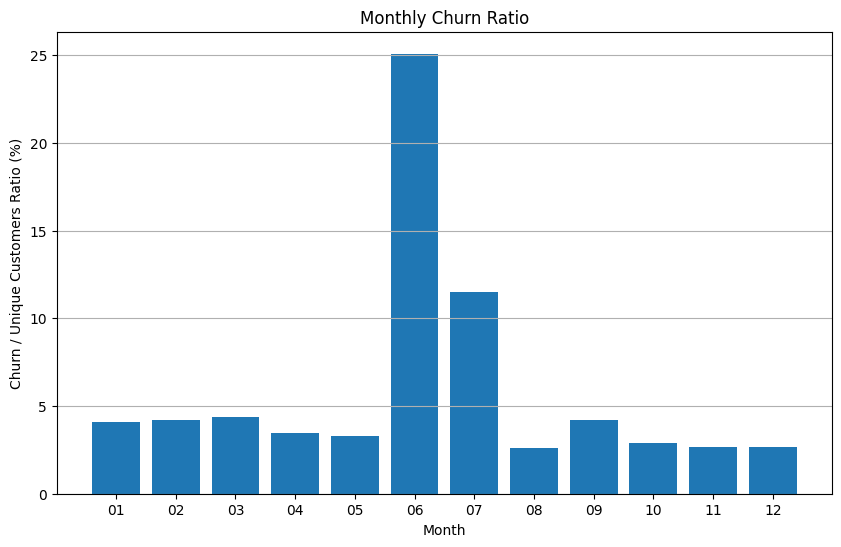

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(result["MONTH"], result["ratio_positive_class"])

plt.xlabel("Month")
plt.ylabel("Churn / Unique Customers Ratio (%)")
plt.title("Monthly Churn Ratio")
plt.grid(axis="y")
plt.show()

First view makes sense, some considerations:
- Heavily unbalanced (3-4% of positive class, but we will even see months with 2.5%). Lots churn ocurred in Jun and July (keep an eye on seasonality too).
- We understand negative payments as refundings; negative consumption as reversals or corrections; negative discounts as penalizations or reversal of previous 
discounts.
- We should decided what to do with customers that joined this month! as for the moment, we will keep them and assign 0 for payments_prev_month and for the avg_3_months it will imputed the current payment.

Let's build our first basic model with the most basic feature engineering

In [91]:
def get_initial_params():
    """
    Loads all relevant parameters into a global variable. These parameters are then accessible to other functions in the script.
    Each function can consume the parameters it requires for its operation.
    This approach ensures centralized management and consistency of parameters across different functions.

    Returns:
        None: This function does not return a value but populates a global variable
        with necessary parameters.
    """
    global train_from, train_to, logistic_regression_params, lightgbm_params

    config = configparser.ConfigParser()
    config.read("src/params.ini")

    train_from = config.get("PARAMS", "train_from")
    train_to = config.get("PARAMS", "train_to")

    # Load Logistic Regression parameters
    logistic_regression_params = {
        "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
        "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
        "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
        "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
    }

    # Load LightGBM parameters
    lightgbm_params = {
        "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
        "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=31),
        "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
        "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.1),
        "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
        "path_smooth": config.getfloat("LIGHTGBM", "path_smooth", fallback=0.0),

    }

In [10]:
def data_gathering(query: str, logger) -> pd.DataFrame:
    """
    Gathers raw data from DB and create a ready-to-use format.

    Returns:
        DataFrame: Pandas DataFrame with collected raw data
    """
    logger.info("Started querying data")
    bq_client = BigqueryService()

    result_df = bq_client.query_to_df(query)
    logger.info(f"Data succesfully retrieved! Length: {len(result_df)}")

    return result_df

In [11]:
def data_cleaning(raw_df: pd.DataFrame, logger) -> pd.DataFrame:
    """
    Cleans raw data by handling missing values, removing duplicates, correcting errors, and performing type conversions for data quality and consistency.
    Returns:
        DataFrame: Pandas DataFrame with cleaned and preprocessed data.
    """
    logger.info("Starting cleaning data")

    # user-info cols to aggregate data later on
    users_cols = ["customer_id", "MONTH", "YEAR"]

    # pre-cooked features
    diff_cols = [
        "dif_pago_final_prev_month",
        "dif_pago_final_prev_2_month",
        "dif_pago_final_prev_3_month",
        "dif_consumo_prev_month",
        "dif_consumo_prev_2_month",
        "dif_consumo_prev_3_month",
        "dif_discount_prev_month",
        "dif_discount_prev_2_month",
        "dif_discount_prev_3_month",
    ]

    # to-be-cooked features
    transform_cols = [
        "pago_final_0",
        "consumo_0",
        "aperiodica_0",
        "discount_0",
        "ajuste_0",
    ]
    # target
    target_col = ["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"]

    filter_df = raw_df[users_cols + diff_cols + transform_cols + target_col]
    clean_df = filter_df.dropna(how="all")

    logger.info("Completed cleaning data!")
    logger.info(clean_df.head())
    return clean_df

In [18]:
def feature_computation(
    clean_data: pd.DataFrame, train_from: str, train_to: str, logger
) -> (pd.DataFrame, pd.Series, pd.DataFrame, pd.Series):
    """
    Split data into train and test features set, aggregate the data into historical behavior for those cols needed.
    It also joins it with already calculated features, and extract the needed target from 2 months ahead.
    Args:
        clean_data: The cleaned dataset with customer, month, and payment information.
        train_from: The starting date of the training period.
        train_to: The ending date of the training period.

    Returns:
        DataFrame: Pandas DataFrame with computed features for model training.
        Series: Pandas Series representing the target variable for train set.
        DataFrame: Pandas DataFrame with computed features for model testing.
        Series: Pandas Series representing the target variable for test set.
    """
    logger.info("Starting feature computation")
    # user-info cols to aggregate data later on
    users_cols = ["customer_id", "MONTH", "YEAR"]

    # pre-cooked features
    diff_cols = [
        "dif_pago_final_prev_month",
        "dif_pago_final_prev_2_month",
        "dif_pago_final_prev_3_month",
        "dif_consumo_prev_month",
        "dif_consumo_prev_2_month",
        "dif_consumo_prev_3_month",
        "dif_discount_prev_month",
        "dif_discount_prev_2_month",
        "dif_discount_prev_3_month",
    ]
    # to-be-cooked features
    transform_cols = [
        "pago_final_0",
        "consumo_0",
        "aperiodica_0",
        "discount_0",
        "ajuste_0",
    ]

    # target
    target_col = ["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"]

    # TO-DO: Catch exceptions
    # TO-DO: Potential unit tests validating same length for features/targets
    # TO-DO: Instead of defining the cols every time import them somewhere else (they're need in data_cleaning also)

    # Convert the train_from and train_to to datetime
    train_from_dt = pd.to_datetime(train_from)
    train_to_dt = pd.to_datetime(train_to)

    # Filter train and test data before feature computation
    test_from_dt = train_from_dt + pd.DateOffset(months=1)
    test_to_dt = train_to_dt + pd.DateOffset(months=1)
    target_train_month = train_to_dt + pd.DateOffset(months=2)
    target_test_month = test_to_dt + pd.DateOffset(months=2)

    logger.info(
        f"Train computation from {train_from_dt} to {train_to_dt}. Target for {target_train_month}"
    )
    logger.info(
        f"Test computation from {test_from_dt} to {test_to_dt}. Target for {target_test_month}"
    )    

    compute_ready_data = clean_data[
        users_cols + transform_cols + diff_cols + target_col
    ].copy()
    train_df, test_df = split_train_test(
        compute_ready_data, train_from_dt, train_to_dt, test_from_dt, test_to_dt
    )

    # Need to remove users that churned previously to train_to/test_to
    previous_churned_users_train = train_df[(train_df['date'] <= train_to_dt) & (train_df[target_col[0]] > 0)]['customer_id'].unique()
    previous_churned_users_test = test_df[(test_df['date'] <= test_to_dt) & (test_df[target_col[0]] > 0)]['customer_id'].unique()
    train_df = train_df[~train_df['customer_id'].isin(previous_churned_users_train)]
    test_df = test_df[~test_df['customer_id'].isin(previous_churned_users_test)]

    logger.info(f"Removing {len(previous_churned_users_train)} previous churned users from train set")
    logger.info(f"Removing {len(previous_churned_users_test)} previous churned users from test set")

    logger.info("Starting features and target computation")

    train_df_features = compute_features(train_df, target_col, train_to_dt)
    test_df_features = compute_features(test_df, target_col, test_to_dt)
    train_df_target = compute_target(
        compute_ready_data, target_col, target_train_month, True
    )
    test_df_target = compute_target(
        compute_ready_data, target_col, target_test_month, True
    )

    logger.info("Features computed")

    # As there are customer that leave between the month we use for training and the target month
    # We have to join the features and the targets and drop those that don't have target. By doing this,
    # we exclude customer that churned in gap month or those with no corresponding record in the target dataset.
    features_and_target_train = train_df_features.merge(
        train_df_target, on="customer_id", how="left"
    )
    features_and_target_test = test_df_features.merge(
        test_df_target, on="customer_id", how="left"
    )

    features_and_target_train = features_and_target_train[
        features_and_target_train[target_col[0]].notna()
    ]

    features_and_target_test = features_and_target_test[
        features_and_target_test[target_col[0]].notna()
    ]

    # Split train and test features + target (squeeze into 1D array)
    features = features_and_target_train.drop(
        columns=target_col + users_cols + ["date"]
    )
    features_test = features_and_target_test.drop(
        columns=target_col + users_cols + ["date"]
    )
    target = features_and_target_train[target_col].squeeze()
    target_test = features_and_target_test[target_col].squeeze()

    logger.info(f"Features: {features.columns.tolist()}")
    logger.info(f"Target: {target.name}")
    logger.info("Completed feature computation!")

    return features, target, features_test, target_test


def split_train_test(
    df: pd.DataFrame,
    train_from: pd.Series,
    train_to: pd.Series,
    test_from: pd.Series,
    test_to: pd.Series,
) -> (pd.DataFrame, pd.DataFrame):
    """
    Split data into train and test.
    Args:
        df: The clean dataset with the columns we want to use as features.
        train_from: The starting date of the training period.
        train_to: The ending date of the training period.
        test_from: The starting date of the testing period.
        test_to: The ending date of the testing period.

    Returns:
        DataFrame: Pandas DataFrame with training months only.
        DataFrame: Pandas DataFrame with testing months only.
    """
    # Create date col to mix month and year
    df["date"] = pd.to_datetime(
        df["YEAR"].astype(str) + "-" + df["MONTH"].astype(str) + "-01"
    )

    # Filter compute_data for the specific date intervals.
    df = df[(df["date"] >= train_from) & (df["date"] <= test_to)]

    train_df = df[(df["date"] >= train_from) & (df["date"] <= train_to)]
    test_df = df[(df["date"] >= test_from) & (df["date"] <= test_to)]

    return train_df, test_df


def compute_features(
    df: pd.DataFrame, target_col: list[str], train_to_dt: pd.Timestamp
) -> pd.DataFrame:
    """
    Compute the features and adds them to the df.
    Args:
        df: The clean dataset with the columns we want to use as features.
        target_col: Name of the target column.

    Returns:
        DataFrame: Pandas DataFrame with new computed variables.
    """

    # TO-DO: The rolling function is propagated backwards for each single month.
    # we just need it for the last one (but for that we need past data also). Didn't find
    # any option to do it with pandas
    df = df.drop(columns=target_col)

    df = df.sort_values(by=["customer_id", "date"])
    df["pago_final_prev_month"] = df.groupby("customer_id")["pago_final_0"].shift(1)
    df["pago_final_prev_month"] = df["pago_final_prev_month"].fillna(0)
    df["pago_final_avg_3_months"] = compute_x_months_avg(df, "pago_final_0", 3)
    df["pago_final_avg_6_months"] = compute_x_months_avg(df, "pago_final_0", 6)
    df["consumo_avg_3_months"] = compute_x_months_avg(df, "consumo_0", 3)
    df["consumo_avg_6_months"] = compute_x_months_avg(df, "consumo_0", 6)
    df["aperiodica_avg_3_months"] = compute_x_months_avg(df, "aperiodica_0", 3)
    df["aperiodica_avg_6_months"] = compute_x_months_avg(df, "aperiodica_0", 6)
    df["discount_avg_3_months"] = compute_x_months_avg(df, "discount_0", 3)
    df["discount_avg_6_months"] = compute_x_months_avg(df, "discount_0", 6)
    df["ajuste_avg_3_months"] = compute_x_months_avg(df, "ajuste_0", 3)
    df["ajuste_avg_6_months"] = compute_x_months_avg(df, "ajuste_0", 6)

    # Filter only the computation backwards from the last month
    df = df[df["date"] == train_to_dt]

    return df


def compute_x_months_avg(
    df: pd.DataFrame, col_name: list[str], months: int
) -> pd.DataFrame:
    """
    Compute the mean of the last months for a column.
    Args:
        df: The clean dataset with the columns we want to use as features.
        col_name: Name of the column to compute
        months: Number of months we want to compute the feature back

    Returns:
        DataFrame: Pandas DataFrame the new computed column.
    """
    return df.groupby("customer_id")[col_name].transform(
        lambda x: x.rolling(window=months, min_periods=1).mean()
    )


def compute_target(
    df: pd.DataFrame,
    target_col: str,
    target_month: pd.Series,
    keep_gap_month_churns: bool = False,
) -> pd.DataFrame:
    """
    Compute the target column for a df.
    Args:
        df: The clean dataset with all the data.
        target_col: Name of the target column.
        target_month: The date where the target has to be computed.
        keep_gap_month_churns: A boolean parameter that determines the treatment of churns occurring in the gap month.
        If True, these churns are treated as actual churns (assigned a value of 1);
        otherwise, they are excluded from the analysis. Defaults to False.
    Returns:
        DataFrame: Pandas DataFrame with the customer_id and the target computed.
    """

    drop_churn_between_month = target_month - pd.DateOffset(months=1)

    target_df = df[
        (df["date"] == target_month) | (df["date"] == drop_churn_between_month)
    ][["customer_id"] + target_col + ["date"]]

    for col in target_col:
        target_df[col].fillna(0, inplace=True)
        target_df[col] = np.where(
            ((target_df[col] > 0) & (target_df["date"] == target_month)),
            1,
            target_df[col],
        )
        target_df[col] = np.where(
            ((target_df[col] > 0) & (target_df["date"] == drop_churn_between_month)),
            2,
            target_df[col],
        )

    if keep_gap_month_churns:
        # Convert all values that are 2 (gap month churns) into 1 (real churns)
        target_df[col] = np.where(target_df[col] == 2, 1, target_df[col])

    # Exclude the records that are still marked as 2 (gap month churns) if keep_gap_month_churns is False
    target_df = target_df[
        (target_df["NUM_DAYS_LINE_TYPE_FIXE_POST_DEA"] != 2)
        & (target_df["date"] != drop_churn_between_month)
    ][["customer_id"] + target_col]

    target_df[target_col] = target_df[target_col].astype("int")

    return target_df

Note about the target! copying comment from PR:

that's a good point. I give a thought while doing that and potentially we need to evalute if we want the model to learn if a user churned in month n+1 although it is not our target. 3 possibilities

- We somehow consider him because the reasons that forced him to churn in month n+1 are very similar to the ones that would make another user to churn in month n+2. Cons: we are giving a prediction for users in n+2 which have high probability to have churned in n+1 (hence prediction totally invalid for this group of customers, we targeted users no longer active)
- We don't consider them and we just focus on features that will determine churn in month n+2. By doing so, we don't mix the prediction for users that might churn in month n+1 vs n+2. Cons: we don't capture the last movements from users behaviour and let the model learn from that pattern.
- Users that churned in month n+1 will be deleted from the database (middle point between the first 2 scenarios)

I'd say there is a trade-off between giving a prediction for high-probability users yet risking they will be no longer with us for that month vs. not capturing last moment churns but making sure we just focus on more future churns. Probably the 2nd is the worst (currently implemented 🎁)

In [201]:
def modeling(
    features: pd.DataFrame, target: pd.Series, lightgbm_params, logger
) -> Pipeline:
    """
    Prepares a machine learning pipeline that scales features and trains a logistic regression model
    with processed data to predict churn.

    Args:
        features (pd.DataFrame): The features to train the model on.
        target (pd.Series): The target variable to predict.

    Returns:
        Pipeline: A pipeline with a standard scaler and a trained logistic regression model.
    """

    logger.info("Starting Modeling")

    # Directly use the logistic_regression_params global variable
    logger.info("Building model pipeline")
    """pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logistic_regression",
                LogisticRegression(
                    penalty=logistic_regression_params["penalty"],
                    C=logistic_regression_params["C"],
                    solver=logistic_regression_params["solver"],
                    max_iter=logistic_regression_params["max_iter"],
                    random_state=42,
                ),
            ),
        ]
    )
    """
    """pipeline = Pipeline(
        [
            (
                "lightgbm",
                lgb.LGBMClassifier(
                    boosting_type=lightgbm_params["boosting_type"],
                    num_leaves=lightgbm_params["num_leaves"],
                    max_depth=lightgbm_params["max_depth"],
                    learning_rate=lightgbm_params["learning_rate"],
                    n_estimators=lightgbm_params["n_estimators"],
                    path_smooth=lightgbm_params["path_smooth"],
                    random_state=42,
                ),
            ),
        ]
    )"""
        # LightGBM model setup
    lightgbm_clf = lgb.LGBMClassifier(random_state=42)

    # Parameter grid for GridSearchCV
    param_grid = {
        'lightgbm__boosting_type': ['gbdt'],  # You can add more types like 'dart', 'goss'
        'lightgbm__num_leaves': [20],  # Vary this based on your dataset size and features
        'lightgbm__max_depth': [-1],  # -1 means no limit
        'lightgbm__learning_rate': [0.01, 0.05, 0.1],
        'lightgbm__n_estimators': [50, 100, 200]
    }

    # Create the pipeline
    pipeline = Pipeline([('lightgbm', lightgbm_clf)])
    
    # GridSearchCV setup
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')  # Adjust scoring method based on your needs

    logger.info("Performing grid search")
    grid_search.fit(features, target)

    logger.info(f"Completed model training! Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    logger.info("Training model")
    model = best_model.fit(features, target)

    logger.info("Completed model training!")

    return model

In [126]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime
import os


def evaluation(
    model,
    features_test: pd.DataFrame,
    target_test: pd.Series,
    logger,
    save_curves_path,
) -> dict[str, str]:
    """
    Assesses trained model's performance using a test dataset and computes metrics like accuracy, precision, recall, and ROC-AUC.

    Returns:
        dict: Dictionary with key performance metrics of the model.
    """
    logger.info(f"Started evaluation for {model}")
    preds = model.predict_proba(features_test)[:, 1]

    # Plotting
    logger.info("Generating plots")

    generate_evaluation_curves(
        model,
        preds,
        target_test,
        save_curves_path,
    )

    preds = model.predict_proba(features_test)
    precision, recall, _ = precision_recall_curve(target_test, preds[:, 1])
    model_metrics = {
        "Precision Curve": precision,
        "Recall Curve": recall,
        # "ROC AUC": roc_auc
    }

    # Calculate Precision in the First Decile
    precision_decile = calculate_precision_first_decile(
        target_test, model.predict_proba(features_test)[:, 1]
    )
    logger.info(f"Precision in the first decile: {precision_decile:.2f}")

    # Calculate Uplift for Each Decile
    uplift_by_decile = calculate_uplift(
        target_test, model.predict_proba(features_test)[:, 1]
    )
    logger.info("Uplift by decile:")
    logger.info(uplift_by_decile)

    logger.info("Completed evaluation!")

    feature_importance_lr = get_feature_importance_logistic_regression(
        model, features_test
    )

    logger.info("Feature importance")
    logger.info(feature_importance_lr.head(10))

    return model_metrics, precision_decile, uplift_by_decile, feature_importance_lr


def calculate_precision_first_decile(target, y_pred_proba):
    """
    Calculate the precision in the first decile of predictions.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - precision_decile (float): Precision in the first decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    decile_cutoff = int(len(data_sorted) * 0.1)
    first_decile = data_sorted.head(decile_cutoff)
    true_positives = first_decile["y_true"].sum()
    precision_decile = true_positives / decile_cutoff

    return precision_decile


def calculate_uplift(target, y_pred_proba):
    """
    Calculate the uplift for each decile.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - pd.Series: Uplift for each decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], 10, labels=False)
    decile_churn_rate = data_sorted.groupby("decile")["y_true"].mean()
    overall_churn_rate = data["y_true"].mean()
    uplift = decile_churn_rate / overall_churn_rate

    return uplift


def generate_evaluation_curves(
    model: str, y_pred, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for a binary classification model
    and save them in a single figure.

    Parameters:
    - model_name (str): Name of the model for labeling the curves.
    - y_pred (array-like): Predicted probabilities or scores.
    - y_test (array-like): True labels.
    - save_curves_path (str, optional): Directory to save the generated figure.
    If None, the figure will not be saved.

    Returns:
    - None
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y_%m_%d")
    model_type = type(model[-1]).__name__  # Assuming 'model' is your pipeline

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_type}")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_type}")
    plt.xlim([-0.005, 1.0])  # Adjusted to start slightly before 0 for a clearer view
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()


def get_feature_importance_logistic_regression(model, features):
    """
    Get feature importance for Logistic Regression model.

    Args:
    - model: Trained Logistic Regression model.
    - feature_names (list or array-like): List of feature names.

    Returns:
    - pd.DataFrame: DataFrame containing feature names and their corresponding coefficients.
    """
    feature_names = features.columns
    # Extract coefficients
    lr_model = model.named_steps["logistic_regression"]
    coefficients = lr_model.coef_[0]  # for Logistic Regression

    # Create a DataFrame for easy visualization
    feature_importance = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    )

    # Sort by absolute value of coefficients in descending order
    feature_importance = feature_importance.reindex(
        feature_importance.Coefficient.abs().sort_values(ascending=False).index
    )

    return feature_importance

In [173]:
query = """
WITH selectable_customer AS
(
        SELECT   customer_id
        FROM     `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
        GROUP BY customer_id ), customer_selected AS
(
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  RAND() < 0.3 )
SELECT     customer_id,
        MONTH,
        YEAR,
        pago_final_0,
        dif_pago_final_prev_month,
        dif_pago_final_prev_2_month,
        dif_pago_final_prev_3_month,
        periodica_0,
        dif_periodica_prev_month,
        dif_periodica_prev_2_month,
        dif_periodica_prev_3_month,
        consumo_0,
        dif_consumo_prev_month,
        dif_consumo_prev_2_month,
        dif_consumo_prev_3_month,
        aperiodica_0,
        dif_aperiodica_prev_month,
        dif_aperiodica_prev_2_month,
        dif_aperiodica_prev_3_month,
        discount_0,
        dif_discount_prev_month,
        dif_discount_prev_2_month,
        dif_discount_prev_3_month,
        ajuste_0,
        dif_ajuste_prev_month,
        dif_ajuste_prev_2_month,
        dif_ajuste_prev_3_month,
        Tota_Compra_disp,
        Curr_Compra_disp,
        Curr_Compra_Finanz_disp,
        Curr_Finanz_disp,
        Month_purchase_disp,
        Modelo_disp,
        Import_Rest_quota_disp,
        pvp_total_disp,
        pvp_total_disp_movil,
        Curr_cancel_disp,
        Tota_cancel_disp NUM_GB_OWNN_CURR,
        NUM_GB_2G_CURR,
        NUM_GB_3G_CURR,
        NUM_GB_4G_CURR,
        NUM_GB_5G_CURR,
        NUM_SESS_CURR,
        NUM_SECS_CURR,
        NUM_CALL_CURR,
        NUM_CALL_WEEK_CURR,
        NUM_CALL_WEEKEND_CURR,
        NUM_SECS_WEEK_CURR,
        NUM_SECS_WEEKEND_CURR,
        NUM_CALL_WEEK,
        NUM_CALL_WEEKEND,
        NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
FROM       `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON         customer_id = selected_customer
WHERE      IS_CUST_SEGM_RESI > 0
AND        IS_CUST_BILL_POST_CURR = TRUE
AND        CUST_BUNDLE_CURR = 'FMC'
AND        NUM_IMPAGOS = 0
AND        pago_final_0 IS NOT NULL
"""
# TO-DO: PARAMETRIZE THIS
save_curves_path = "src/models"

In [197]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb

def modeling(features: pd.DataFrame, target: pd.Series, lightgbm_params, logger) -> Pipeline:
    """
    Prepares a machine learning pipeline that trains a LightGBM model with processed data to predict churn.

    Args:
        features (pd.DataFrame): The features to train the model on.
        target (pd.Series): The target variable to predict.

    Returns:
        Pipeline: A pipeline with a trained LightGBM model.
    """

    logger.info("Starting Modeling")
    logger.info("Building model pipeline")

    # Building the LightGBM pipeline
    pipeline = Pipeline(
        [
            (
                "lightgbm",
                lgb.LGBMClassifier(
                    boosting_type=lightgbm_params["boosting_type"],
                    num_leaves=lightgbm_params["num_leaves"],
                    max_depth=lightgbm_params["max_depth"],
                    learning_rate=lightgbm_params["learning_rate"],
                    n_estimators=lightgbm_params["n_estimators"],
                    path_smooth=lightgbm_params["path_smooth"],
                    random_state=43,
                    verbosity = 0,
                ),
            ),
        ]
    )

    logger.info("Training model")
    model = pipeline.fit(features, target)

    logger.info("Completed model training!")

    return model


In [187]:
sample[sample['NUM_DAYS_LINE_TYPE_FIXE_POST_DEA'] > 0]

,customer_id,MONTH,YEAR,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,consumo_0,dif_consumo_prev_month,dif_consumo_prev_2_month,dif_consumo_prev_3_month,aperiodica_0,dif_aperiodica_prev_month,dif_aperiodica_prev_2_month,dif_aperiodica_prev_3_month,discount_0,dif_discount_prev_month,dif_discount_prev_2_month,dif_discount_prev_3_month,ajuste_0,dif_ajuste_prev_month,dif_ajuste_prev_2_month,dif_ajuste_prev_3_month,Tota_Compra_disp,Curr_Compra_disp,Curr_Compra_Finanz_disp,Curr_Finanz_disp,Month_purchase_disp,Modelo_disp,Import_Rest_quota_disp,pvp_total_disp,pvp_total_disp_movil,Curr_cancel_disp,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,NUM_GB_5G_CURR,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
12,290129,02,2022,147.5350,-2.02,-2.02,-1.42,301.0519,-0.25,-0.25,-0.25,533.4890,157.87,12.84,-7.70,0.0,0.0,0.0,0.0,-687.0059,-159.64,-14.62,6.52,0.0,0.0,0.0,0.0,6,0,0,0,14,1,49.587500,2037.53,2037.53,0,0,0.001625,0.339503,21.078657,0.000000,25721,96954,872,730,142,88384,8570,623,124,25
19,2200244,05,2022,36.0847,-118.61,-126.42,-79.26,119.9830,-107.01,-106.04,-100.23,266.2682,123.41,45.40,109.89,150.0,150.0,150.0,150.0,-500.1665,-285.01,-215.78,-238.92,0.0,0.0,0.0,0.0,6,0,0,1,4,1,99.175000,1989.26,1989.26,0,0,0.001379,1.090961,124.427688,0.008954,35386,92825,1262,1127,135,84483,8342,792,98,25
28,1349556,11,2022,143.8690,-15.44,-1.38,4.51,202.6527,1.36,1.36,2.20,116.5707,-25.70,14.69,-27.29,120.0,120.0,120.0,120.0,-295.3544,-111.10,-137.43,-90.40,0.0,0.0,0.0,0.0,8,0,0,0,18,1,49.587500,2508.77,2508.77,0,0,0.001252,2.996683,16.942531,10.348676,15548,26450,398,354,44,22419,4031,293,36,9
67,2409338,11,2022,154.6531,18.95,13.30,35.67,139.7557,0.00,0.00,0.00,334.0686,74.63,129.10,58.70,0.0,0.0,-22.0,0.0,-319.1712,-55.68,-93.80,-23.02,0.0,0.0,0.0,0.0,8,0,0,2,9,2,1021.488750,3292.55,2975.19,0,0,0.000153,0.307437,21.777536,23.630717,22878,57695,1051,875,176,48121,9574,725,162,26
81,2165717,12,2022,95.3785,-4.20,-29.26,0.50,160.9236,7.16,7.16,7.16,167.6168,7.29,6.82,19.05,0.0,0.0,0.0,0.0,-233.1619,-18.66,-43.23,-25.71,0.0,0.0,0.0,0.0,6,0,0,1,4,1,66.116667,1115.91,1115.91,0,0,0.000797,1.490302,12.665499,0.000000,10863,65683,530,420,110,58848,6835,310,75,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283403,1920418,11,2022,111.4564,1.24,-1.99,-19.68,270.4156,0.00,-0.74,-11.53,257.5305,118.39,144.88,38.26,0.0,0.0,0.0,0.0,-416.4897,-117.15,-146.12,-46.41,0.0,0.0,0.0,0.0,5,0,0,0,25,1,NaN,897.52,897.52,0,0,0.004304,0.668010,26.364115,0.000000,11335,53859,754,622,132,49303,4556,500,100,5
283407,2225663,06,2022,112.6387,-0.66,-6.39,-4.40,212.1971,-0.67,-5.00,-5.00,325.9767,149.16,38.04,144.38,0.0,0.0,0.0,0.0,-425.5351,-149.16,-39.44,-143.77,0.0,0.0,0.0,0.0,5,0,0,0,37,1,NaN,1119.48,1069.89,0,0,0.000056,0.038329,6.497412,0.001674,5470,69041,531,462,69,54980,14061,333,54,2
283425,266172,02,2022,110.6792,4.69,4.39,4.69,138.1139,0.63,0.63,0.63,59.9144,-9.29,27.15,-9.07,0.0,0.0,0.0,0.0,-87.3491,13.35,-23.39,13.13,0.0,0.0,0.0,0.0,5,0,0,0,6,1,89.257500,807.87,807.87,0,0,0.000063,0.004787,1.905787,0.000000,2246,10786,168,137,31,8696,2090,123,25,20
283431,528397,06,2022,69.7310,-0.22,-0.22,1.78,167.7152,15.66,15.66,16.00,254.9718,-12.81,-71.59,49.12,0.0,0.0,0.0,0.0,-352.9560,-3.07,55.71,-63.35,0.0,0.0,0.0,0.0,5,0,0,1,8,1,171.900000,1029.23,1029.23,0,0,0.000000,0.155690,30.178617,2.605865,10085,98207,539,393,146,75960,22247,297,85,23


In [189]:
sample[sample['customer_id'] ==  '2225663'].sort_values('MONTH')

,customer_id,MONTH,YEAR,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,consumo_0,dif_consumo_prev_month,dif_consumo_prev_2_month,dif_consumo_prev_3_month,aperiodica_0,dif_aperiodica_prev_month,dif_aperiodica_prev_2_month,dif_aperiodica_prev_3_month,discount_0,dif_discount_prev_month,dif_discount_prev_2_month,dif_discount_prev_3_month,ajuste_0,dif_ajuste_prev_month,dif_ajuste_prev_2_month,dif_ajuste_prev_3_month,Tota_Compra_disp,Curr_Compra_disp,Curr_Compra_Finanz_disp,Curr_Finanz_disp,Month_purchase_disp,Modelo_disp,Import_Rest_quota_disp,pvp_total_disp,pvp_total_disp_movil,Curr_cancel_disp,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,NUM_GB_5G_CURR,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
283331,2225663,01,2022,117.3342,-0.80,1.30,6.07,217.1971,0.30,1.00,1.93,219.4908,-30.65,-15.24,62.35,0.0,0.0,0.0,0.0,-319.3537,29.55,15.54,-58.21,0.0,0.0,0.0,0.0,5,0,0,0,32,1,NaN,1119.48,1069.89,0,0,0.000000e+00,0.009498,2.759064,0.000000,4052,53857,329,278,51,42458,11399,222,41,<NA>
282096,2225663,02,2022,117.0342,-0.30,-1.10,1.00,217.1971,0.00,0.30,1.00,147.0588,-72.43,-103.08,-87.67,0.0,0.0,0.0,0.0,-247.2217,72.13,101.68,87.67,0.0,0.0,0.0,0.0,5,0,0,0,33,1,NaN,1119.48,1069.89,0,0,7.720664e-06,0.010632,2.783493,0.000000,3501,32407,300,253,47,29126,3281,212,42,<NA>
283341,2225663,03,2022,117.0342,0.00,-0.30,-1.10,217.1971,0.00,0.00,0.30,181.5981,34.54,-37.89,-68.54,0.0,0.0,0.0,0.0,-281.7610,-34.54,37.59,67.14,0.0,0.0,0.0,0.0,5,0,0,0,34,1,NaN,1119.48,1069.89,0,0,2.936088e-05,0.041953,5.207982,0.000630,4099,54918,464,402,62,48053,6865,299,43,<NA>
282914,2225663,04,2022,119.0307,2.00,2.00,1.70,217.1971,0.00,0.00,0.00,287.9319,106.33,140.87,68.44,0.0,0.0,0.0,0.0,-386.0983,-104.34,-138.88,-66.74,0.0,0.0,0.0,0.0,5,0,0,0,35,1,NaN,1119.48,1069.89,0,0,0.000000e+00,0.090506,22.159287,0.000708,5304,69787,390,314,76,60616,9171,237,64,<NA>
282751,2225663,05,2022,113.3018,-5.73,-3.73,-3.73,212.8638,-4.33,-4.33,-4.33,176.8163,-111.12,-4.78,29.76,0.0,0.0,0.0,0.0,-276.3783,109.72,5.38,-29.16,0.0,0.0,0.0,0.0,5,0,0,0,36,1,NaN,1119.48,1069.89,0,0,2.402812e-07,0.035609,4.958757,0.007685,4610,55238,374,316,58,47103,8135,252,51,<NA>
283407,2225663,06,2022,112.6387,-0.66,-6.39,-4.40,212.1971,-0.67,-5.00,-5.00,325.9767,149.16,38.04,144.38,0.0,0.0,0.0,0.0,-425.5351,-149.16,-39.44,-143.77,0.0,0.0,0.0,0.0,5,0,0,0,37,1,NaN,1119.48,1069.89,0,0,5.626213e-05,0.038329,6.497412,0.001674,5470,69041,531,462,69,54980,14061,333,54,2
282805,2225663,07,2022,111.4449,-1.19,-1.86,-7.59,220.4594,8.26,7.60,3.26,329.3562,3.38,152.54,41.42,0.0,0.0,0.0,0.0,-438.3707,-12.84,-161.99,-52.27,0.0,0.0,0.0,0.0,5,0,0,0,38,1,NaN,1119.48,1069.89,0,0,1.539048e-04,0.108643,16.961215,0.083642,8423,86277,413,294,119,59081,27196,250,78,<NA>
281935,2225663,08,2022,112.0449,0.60,-0.59,-1.26,225.9582,5.50,13.76,13.09,208.5620,-120.79,-117.41,31.75,0.0,0.0,0.0,0.0,-322.4753,115.90,103.06,-46.10,0.0,0.0,0.0,0.0,5,0,0,0,39,1,NaN,1119.48,1069.89,0,0,0.000000e+00,0.042085,11.885919,0.012503,5560,63194,279,214,65,38523,24671,185,54,<NA>
282752,2225663,09,2022,112.3449,0.30,0.90,-0.29,225.9582,0.00,5.50,13.76,209.3361,0.77,-120.02,-116.64,0.0,0.0,0.0,0.0,-322.9494,-0.47,115.42,102.59,0.0,0.0,0.0,0.0,5,0,0,0,40,1,NaN,1119.48,1069.89,0,0,7.655472e-07,0.064293,6.507993,0.021919,5189,58790,359,325,34,48916,9874,268,26,<NA>
282902,2225663,10,2022,112.0449,-0.30,0.00,0.60,225.9582,0.00,0.00,5.50,215.1073,5.77,6.55,-114.25,0.0,0.0,0.0,0.0,-329.0206,-6.07,-6.55,109.35,0.0,0.0,0.0,0.0,5,0,0,0,41,1,NaN,1119.48,1069.89,0,0,1.512533e-04,0.035633,14.493573,0.010433,6210,57871,467,360,107,39538,18333,302,85,<NA>


INFO - Started querying data
INFO - Data succesfully retrieved! Length: 857673
INFO - Starting cleaning data
INFO - Completed cleaning data!
INFO -   customer_id MONTH  YEAR  dif_pago_final_prev_month  \
0     1899895    10  2022                      21.84   
1      528595    01  2022                     -44.65   
2      579499    11  2022                      -0.30   
3      465038    05  2022                       0.00   
4     1996659    01  2022                      19.90   

   dif_pago_final_prev_2_month  dif_pago_final_prev_3_month  \
0                        22.44                        -2.70   
1                       -23.18                       -20.68   
2                         0.00                         0.00   
3                         0.00                        -2.42   
4                        12.97                        28.30   

   dif_consumo_prev_month  dif_consumo_prev_2_month  dif_consumo_prev_3_month  \
0                  -73.33                    -42.73    

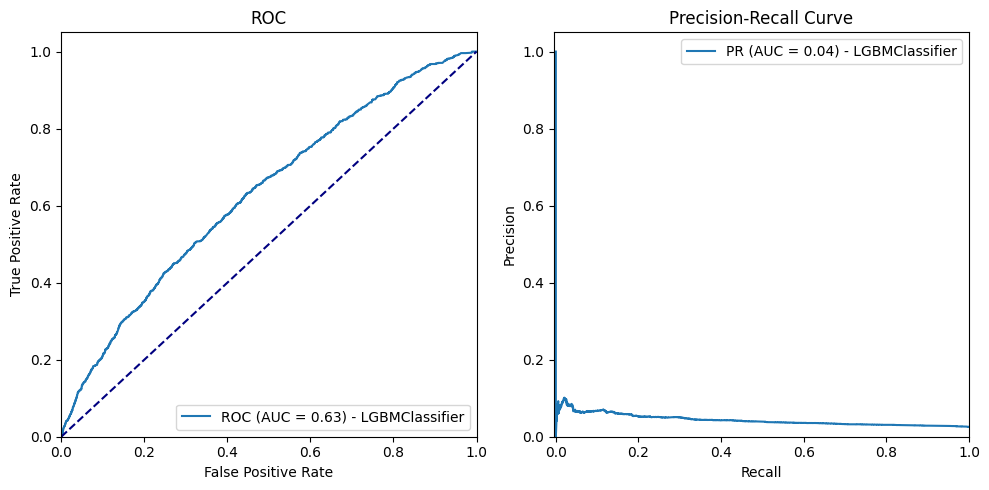

INFO - Precision in the first decile: 0.05
INFO - Uplift by decile:
INFO - decile
0    0.322372
1    0.655327
2    0.701615
3    0.823653
4    0.772315
5    0.977614
6    1.036014
7    1.231794
8    1.437093
9    2.042706
Name: y_true, dtype: float64
INFO - Completed evaluation!


KeyError: 'logistic_regression'

In [175]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

INFO - Starting Modeling
INFO - Building model pipeline
INFO - Performing grid search


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 850, number of negative: 30382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5549
[LightGBM] [Info] Number of data points in the train set: 31232, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027216 -> initscore=-3.576369
[LightGBM] [Info] Start training from score -3.576369
[LightGBM] [Info] Number of positive: 850, number of negative: 30383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5544
[LightGBM] [Info] Number of data points in the train set: 31233, number of used features: 25
[LightGBM] [Info] [binar

INFO - Completed model training! Best parameters: {'lightgbm__boosting_type': 'gbdt', 'lightgbm__learning_rate': 0.01, 'lightgbm__max_depth': 3, 'lightgbm__n_estimators': 50, 'lightgbm__num_leaves': 20}
INFO - Training model


[LightGBM] [Info] Number of positive: 1063, number of negative: 37978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5573
[LightGBM] [Info] Number of data points in the train set: 39041, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027228 -> initscore=-3.575912
[LightGBM] [Info] Start training from score -3.575912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(learning_rate=0.01, max_depth=3,
                                n_estimators=50, num_leaves=20,
                                random_state=42))])
INFO - Generating plots


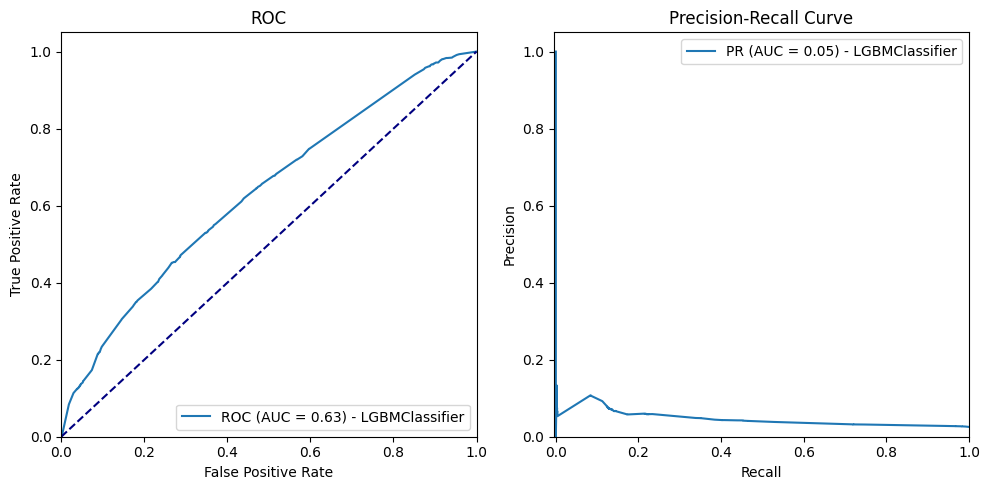

INFO - Precision in the first decile: 0.06


ValueError: Bin edges must be unique: array([0.01809181, 0.02064481, 0.02378316, 0.02378316, 0.02397031,
       0.02519372, 0.02716088, 0.02812579, 0.03105502, 0.03179735,
       0.05041573]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [195]:
get_initial_params()
#raw_data = data_gathering(query, logger)
#clean_data = data_cleaning(raw_data, logger)
#features, target, features_test, target_test = feature_computation(
#    clean_data, train_from, train_to, logger
#)
model = modeling(features, target, logistic_regression_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

INFO - Starting Modeling
INFO - Building model pipeline
INFO - Training model
INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(learning_rate=0.05, n_estimators=50,
                                num_leaves=20, path_smooth=0.5, random_state=43,
                                verbosity=0))])
INFO - Generating plots


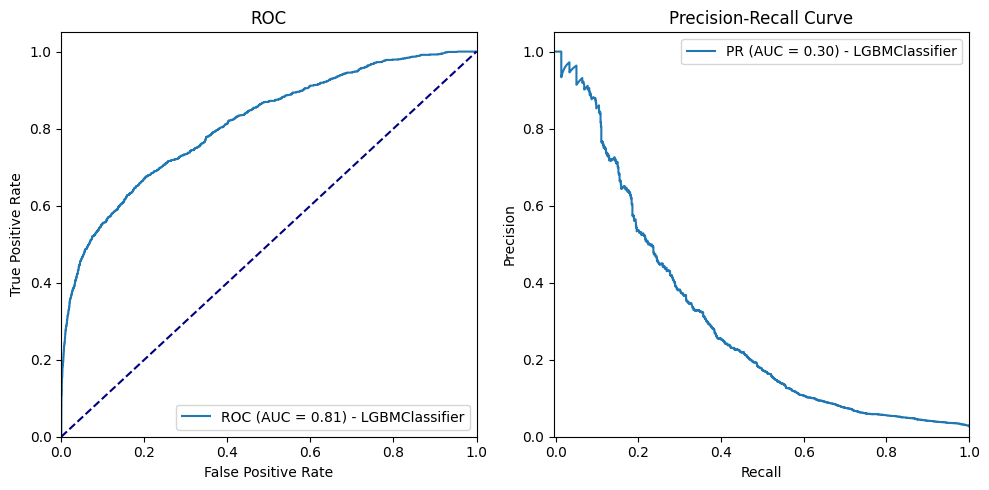

INFO - Precision in the first decile: 0.15
INFO - Uplift by decile:
INFO - decile
0    0.075241
1    0.141078
2    0.329350
3    0.404526
4    0.357488
5    0.658531
6    0.752606
7    0.724384
8    1.204170
9    5.352912
Name: y_true, dtype: float64
INFO - Completed evaluation!


KeyError: 'logistic_regression'

In [200]:
get_initial_params()
#raw_data = data_gathering(query, logger)
#clean_data = data_cleaning(raw_data, logger)
#features, target, features_test, target_test = feature_computation(
#    clean_data, train_from, train_to, logger
#)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features, target, logger, save_curves_path
)

In [191]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb

def modeling(features: pd.DataFrame, target: pd.Series, logistic_regression_params, logger) -> Pipeline:
    """
    Prepares a machine learning pipeline that trains a LightGBM model with processed data to predict churn.

    Args:
        features (pd.DataFrame): The features to train the model on.
        target (pd.Series): The target variable to predict.

    Returns:
        Pipeline: A pipeline with a trained LightGBM model.
    """

    logger.info("Starting Modeling")
    logger.info("Building model pipeline")

    # Building the Logistic Regression pipeline
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logistic_regression",
                LogisticRegression(
                    penalty=logistic_regression_params["penalty"],
                    C=logistic_regression_params["C"],
                    solver=logistic_regression_params["solver"],
                    max_iter=logistic_regression_params["max_iter"],
                    random_state=42,
                ),
            ),
        ]
    )

    logger.info("Training model")
    model = pipeline.fit(features, target)

    logger.info("Completed model training!")

    return model


INFO - Starting Modeling
INFO - Building model pipeline
INFO - Training model
INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=1e-08, max_iter=10000, random_state=42,
                                    solver='saga'))])
INFO - Generating plots


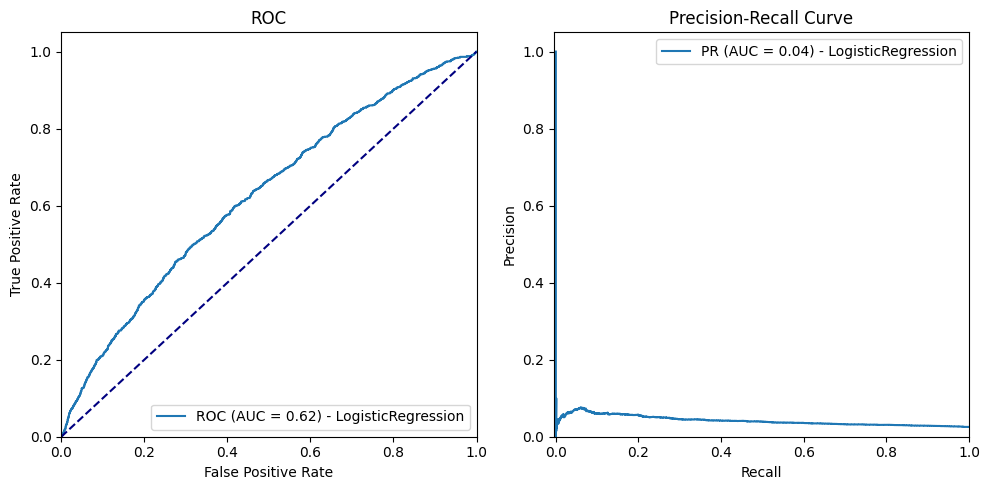

INFO - Precision in the first decile: 0.05
INFO - Uplift by decile:
INFO - decile
0    0.439817
1    0.586569
2    0.674554
3    0.830766
4    0.840748
5    0.889629
6    1.055561
7    1.182913
8    1.397988
9    2.101348
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                         Feature  Coefficient
0                  pago_final_0     0.000003
19      aperiodica_avg_3_months     0.000002
15      pago_final_avg_3_months     0.000002
16      pago_final_avg_6_months     0.000002
7   dif_pago_final_prev_3_month     0.000002
22        discount_avg_6_months    -0.000002
3                    discount_0    -0.000002
21        discount_avg_3_months    -0.000002
20      aperiodica_avg_6_months     0.000002
14        pago_final_prev_month     0.000002


In [192]:
get_initial_params()
#raw_data = data_gathering(query, logger)
#clean_data = data_cleaning(raw_data, logger)
#features, target, features_test, target_test = feature_computation(
#    clean_data, train_from, train_to, logger
#)
model = modeling(features, target, logistic_regression_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

orchestrator()

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 286091
INFO - Starting cleaning data
INFO - Completed cleaning data!
INFO -   customer_id MONTH  YEAR  dif_pago_final_prev_month  \
0      291697    07  2022                      -0.90   
1     1695998    05  2022                       0.00   
2     1757238    01  2022                      11.49   
3     1354778    07  2022                      -4.22   
4      239880    04  2022                       5.00   

   dif_pago_final_prev_2_month  dif_pago_final_prev_3_month  \
0                        -5.75                         0.00   
1                        -0.30                         0.00   
2                        16.76                        20.96   
3                        -1.49                       -11.83   
4                       -23.33                       -46.26   

   dif_consumo_prev_month  dif_consumo_prev_2_month  dif_consumo_prev_3_month  \
0                  -39.36                   -109.72    

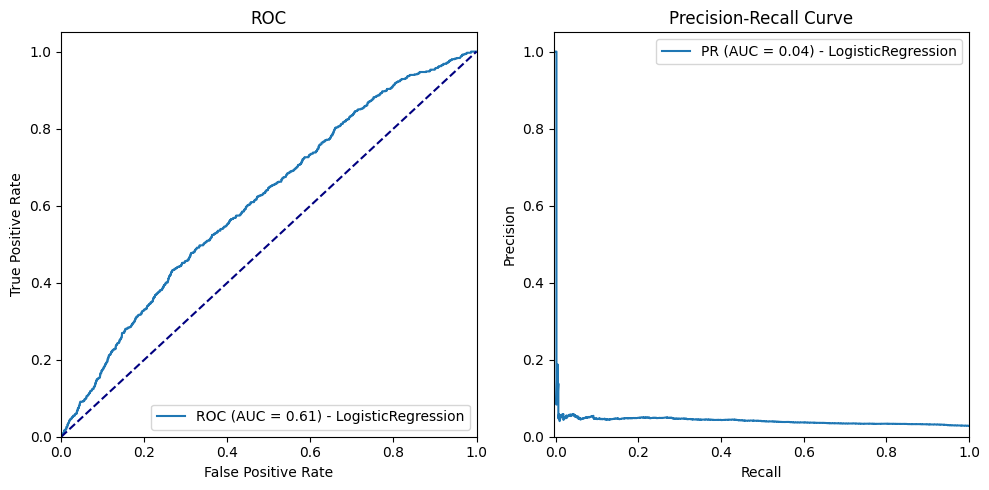

INFO - Precision in the first decile: 0.05
INFO - Uplift by decile:
INFO - decile
0    0.469657
1    0.454507
2    0.757511
3    1.030653
4    0.893863
5    0.939314
6    0.939713
7    1.257469
8    1.530173
9    1.727126
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                       Feature  Coefficient
0                pago_final_0     0.554384
12  dif_discount_prev_2_month    -0.485231
9    dif_consumo_prev_2_month    -0.428361
20    aperiodica_avg_6_months    -0.421299
19    aperiodica_avg_3_months     0.386799
14      pago_final_prev_month    -0.367461
22      discount_avg_6_months    -0.280407
10   dif_consumo_prev_3_month     0.271339
13  dif_discount_prev_3_month     0.269438
18       consumo_avg_6_months    -0.265216


In [30]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)
model = modeling(features, target, logistic_regression_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features, target, logger, save_curves_path
)

In [58]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def modeling(
    features: pd.DataFrame, target: pd.Series, logistic_regression_params, logger
) -> Pipeline:
    """
    Prepares a machine learning pipeline that scales features and trains a logistic regression model
    with processed data to predict churn.

    Args:
        features (pd.DataFrame): The features to train the model on.
        target (pd.Series): The target variable to predict.

    Returns:
        Pipeline: A pipeline with a standard scaler and a trained logistic regression model.
    """

    logger.info("Starting Modeling")

    # Directly use the logistic_regression_params global variable
    logger.info("Building model pipeline")
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "logistic_regression",
                LogisticRegression(
                    penalty=logistic_regression_params["penalty"],
                    C=logistic_regression_params["C"],
                    solver=logistic_regression_params["solver"],
                    max_iter=logistic_regression_params["max_iter"],
                    random_state=42,
                ),
            ),
        ]
    )
    """
    pipeline = Pipeline(
        [
            (
                "lightgbm",
                lgb.LGBMClassifier(
                    boosting_type=lightgbm_params["boosting_type"],
                    num_leaves=lightgbm_params["num_leaves"],
                    max_depth=lightgbm_params["max_depth"],
                    learning_rate=lightgbm_params["learning_rate"],
                    n_estimators=lightgbm_params["n_estimators"],
                    random_state=42,
                ),
            ),
        ]
    )"""

    logger.info("Training model")
    model = pipeline.fit(features, target)

    logger.info("Completed model training!")

    return model

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 855923
INFO - Starting cleaning data
INFO - Completed cleaning data!
INFO -   customer_id MONTH  YEAR  dif_pago_final_prev_month  \
0      199882    12  2022                     -57.76   
1     1472742    09  2022                       0.00   
2       36290    04  2022                       3.30   
3     2093124    12  2022                      -3.79   
4     2257934    09  2022                       0.60   

   dif_pago_final_prev_2_month  dif_pago_final_prev_3_month  \
0                       -53.80                       -52.73   
1                        -1.00                         2.50   
2                         3.30                         3.30   
3                       -15.32                       -24.11   
4                         2.50                        10.60   

   dif_consumo_prev_month  dif_consumo_prev_2_month  dif_consumo_prev_3_month  \
0                  -27.61                    -28.53    

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 853, number of negative: 30442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5544
[LightGBM] [Info] Number of data points in the train set: 31295, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027257 -> initscore=-3.574819
[LightGBM] [Info] Start training from score -3.574819
[LightGBM] [Info] Number of positive: 853, number of negative: 30442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train se

INFO - Completed model training! Best parameters: {'lightgbm__boosting_type': 'gbdt', 'lightgbm__learning_rate': 0.01, 'lightgbm__max_depth': -1, 'lightgbm__n_estimators': 50, 'lightgbm__num_leaves': 20}
INFO - Training model


[LightGBM] [Info] Number of positive: 1066, number of negative: 38053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5572
[LightGBM] [Info] Number of data points in the train set: 39119, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027250 -> initscore=-3.575067
[LightGBM] [Info] Start training from score -3.575067


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(learning_rate=0.01, n_estimators=50,
                                num_leaves=20, random_state=42))])
INFO - Generating plots


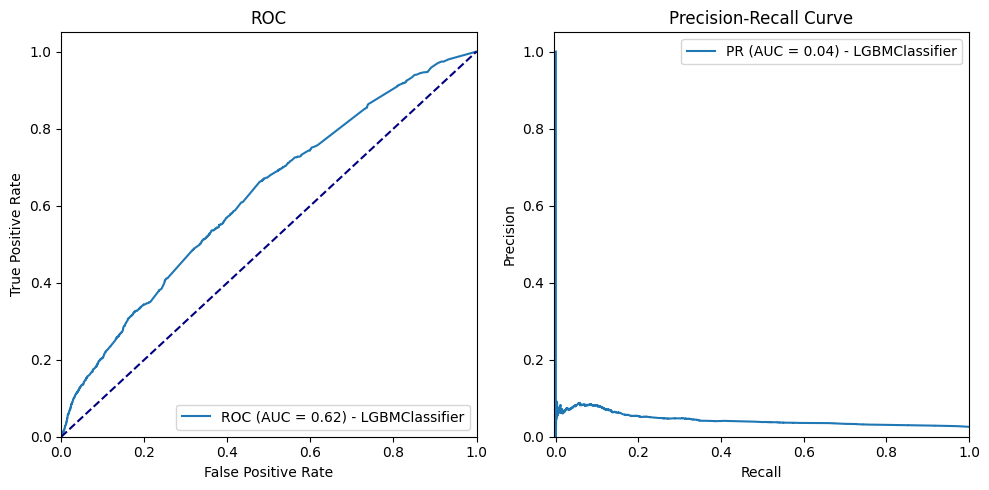

INFO - Precision in the first decile: 0.05
INFO - Uplift by decile:
INFO - decile
0    0.385461
1    0.633635
2    0.871024
3    0.646199
4    0.711755
5    1.076060
6    1.092991
7    1.166446
8    1.386954
9    2.037813
Name: y_true, dtype: float64
INFO - Completed evaluation!


KeyError: 'logistic_regression'

In [203]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(learning_rate=0.01, n_estimators=50,
                                num_leaves=20, random_state=42))])
INFO - Generating plots


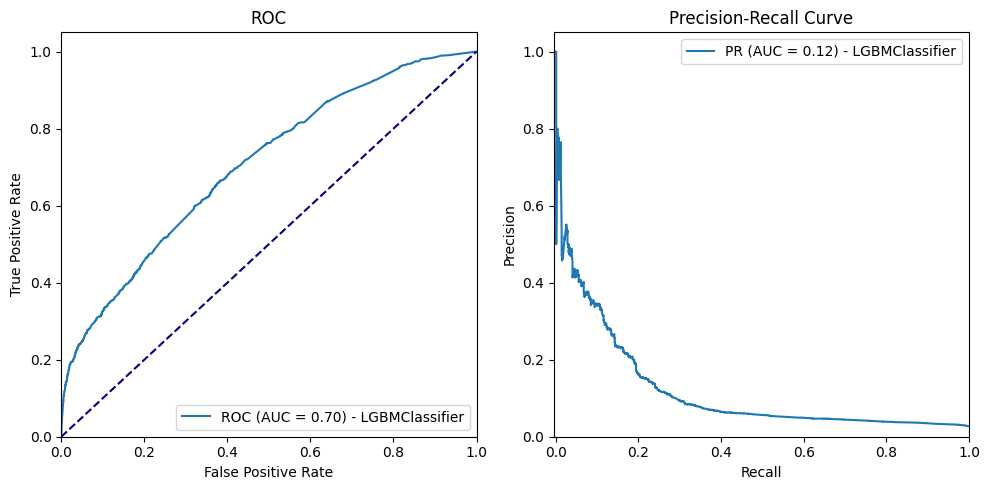

INFO - Precision in the first decile: 0.09
INFO - Uplift by decile:
INFO - decile
0    0.158709
1    0.431138
2    0.451393
3    0.800985
4    0.606137
5    0.910153
6    1.080578
7    1.179350
8    1.334778
9    3.137941
Name: y_true, dtype: float64
INFO - Completed evaluation!


KeyError: 'logistic_regression'

In [204]:
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features, target, logger, save_curves_path
)